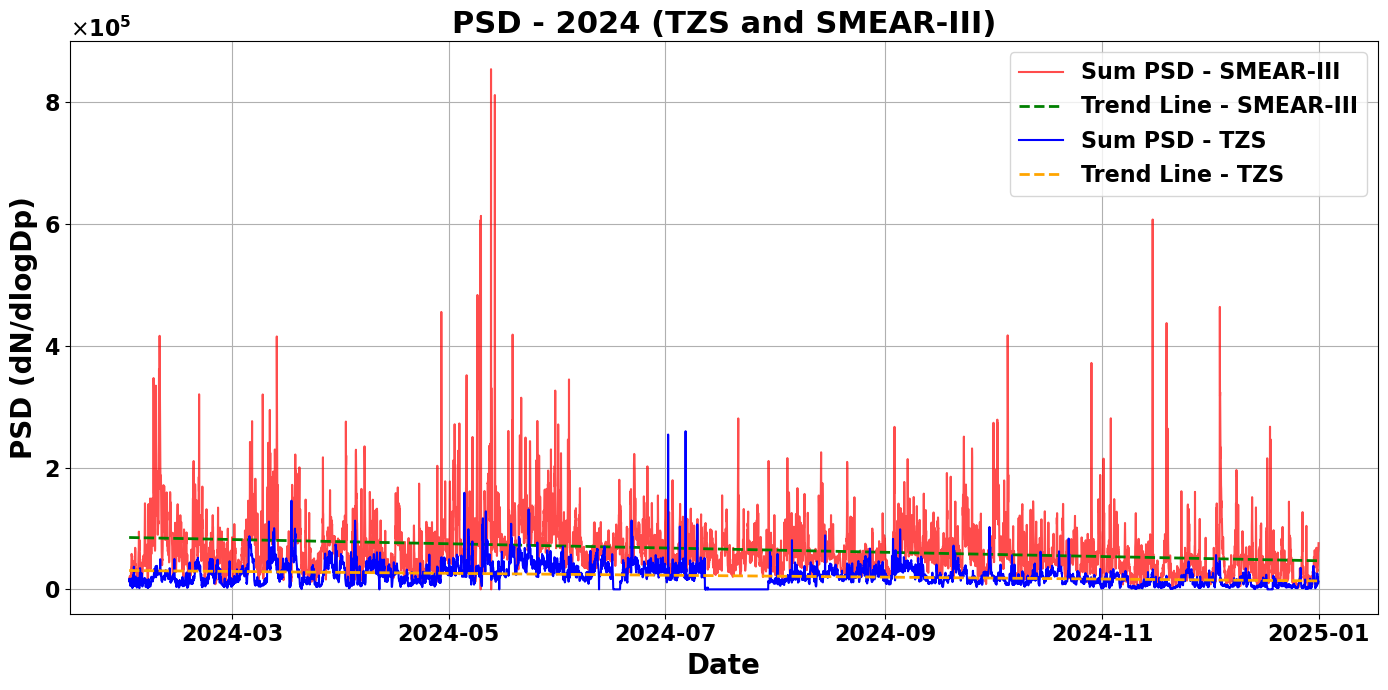

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- Load the data from the Excel file ---
file_path = '/Users/touqeergill/Desktop/SMEAER + TZS (PSD) ORG.xlsx'

# Read each sheet separately
tzs_data = pd.read_excel(file_path, sheet_name='TZS')
smear_data = pd.read_excel(file_path, sheet_name='SMEAR')

# --- Processing TZS Data ---
# Sum the PSD values across particle size bins (assuming columns 2 to 40)
tzs_data['Sum_PSD'] = tzs_data.iloc[:, 1:40].sum(axis=1)

# Convert 'datetime' to datetime type
tzs_data['Date'] = pd.to_datetime(tzs_data['Date'])
tzs_data['timestamp'] = tzs_data['Date'].map(pd.Timestamp.timestamp)

# Perform linear regression for TZS
slope_tzs, intercept_tzs = np.polyfit(tzs_data['timestamp'], tzs_data['Sum_PSD'], 1)
trend_line_tzs = slope_tzs * tzs_data['timestamp'] + intercept_tzs

# --- Processing SMEAR Data ---
# Sum the PSD values across particle size bins (assuming columns 2 to 40)
smear_data['Sum_PSD'] = smear_data.iloc[:, 1:40].sum(axis=1)

# Convert 'datetime' to datetime type
smear_data['Date'] = pd.to_datetime(smear_data['Date'])
smear_data['timestamp'] = smear_data['Date'].map(pd.Timestamp.timestamp)

# Perform linear regression for SMEAR
slope_smear, intercept_smear = np.polyfit(smear_data['timestamp'], smear_data['Sum_PSD'], 1)
trend_line_smear = slope_smear * smear_data['timestamp'] + intercept_smear

# --- Plotting ---
plt.figure(figsize=(14, 7))

# First plot SMEAR (red, background)
plt.plot(smear_data['Date'], smear_data['Sum_PSD'], linestyle='-', color='red', alpha=0.7, label='Sum PSD - SMEAR-III')
plt.plot(smear_data['Date'], trend_line_smear, color='green', linestyle='--', linewidth=2, label='Trend Line - SMEAR-III')  # Trend line in black

# Then plot TZS (blue, foreground)
plt.plot(tzs_data['Date'], tzs_data['Sum_PSD'], linestyle='-', color='blue', label='Sum PSD - TZS')
plt.plot(tzs_data['Date'], trend_line_tzs, color='orange', linestyle='--', linewidth=2, label='Trend Line - TZS')  # Trend line in orange

# --- Customizing the Plot ---
plt.title('PSD - 2024 (TZS and SMEAR-III)', fontweight='bold', fontsize=22)
plt.xlabel('Date', fontweight='bold', fontsize=20)
plt.ylabel('PSD (dN/dlogDp)', fontweight='bold', fontsize=20)

plt.grid(True)
plt.ylim(-40000, 900000)

# Scientific notation for Y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Tick styling
plt.xticks(fontweight='bold', fontsize=16, rotation=0)
plt.yticks(fontweight='bold', fontsize=16)
plt.gca().yaxis.get_offset_text().set_fontsize(16)
plt.gca().yaxis.get_offset_text().set_fontweight('bold')

# Legend
plt.legend(prop={'size': 16, 'weight': 'bold'})

# Tight layout
plt.tight_layout()

# --- Display the Plot ---
plt.show()

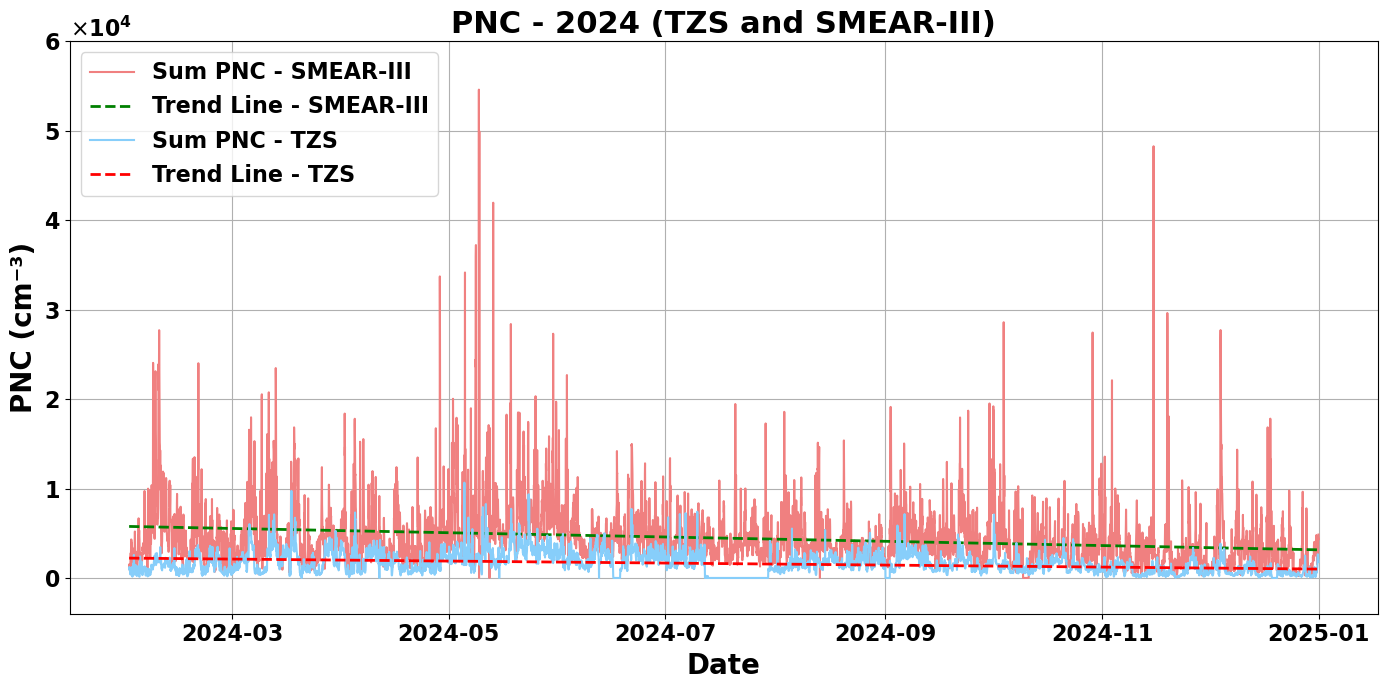

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# =============== Settings ===============
file_path = '/Users/touqeergill/Desktop/TZS + SMEAR (PNC)+ CPC.xlsx'

Y_LIMS = (-4000, 60000)

# Colors
SMEAR_SERIES_COLOR = 'lightcoral'
SMEAR_TREND_COLOR  = 'green'
TZS_SERIES_COLOR   = 'lightskyblue'
TZS_TREND_COLOR    = 'red'
# =======================================

# --- Load the data from the Excel file ---
tzs_data   = pd.read_excel(file_path, sheet_name='TZS')
smear_data = pd.read_excel(file_path, sheet_name='SMEAR')

# --- Ensure there's a 'datetime' column and parse it ---
def ensure_datetime(df):
    dt_col = None
    for c in df.columns:
        if str(c).strip().lower() == 'datetime':
            dt_col = c
            break
    if dt_col is None:
        raise KeyError("No 'datetime' column found (case-insensitive) in one of the sheets.")
    df['datetime'] = pd.to_datetime(df[dt_col])
    return df

tzs_data   = ensure_datetime(tzs_data)
smear_data = ensure_datetime(smear_data)

# --- Sum the PNC values across particle size bins ---
# Assumes columns 2..40 are PNC bins (df.columns[1:40]). Adjust if your bin range differs.
def sum_pnc_bins(df):
    end_idx = min(40, df.shape[1])           # up to column index 39 (inclusive)
    candidate_cols = df.columns[1:end_idx]   # skip datetime in col 0
    nums = df[candidate_cols].select_dtypes(include='number')
    if nums.shape[1] == 0:
        # fallback: sum all numeric columns except 'datetime'
        nums = df.drop(columns=['datetime'], errors='ignore').select_dtypes(include='number')
    return nums.sum(axis=1)

tzs_data['Sum_PNC']   = sum_pnc_bins(tzs_data)
smear_data['Sum_PNC'] = sum_pnc_bins(smear_data)

# --- Convert datetimes to timestamps for regression ---
tzs_data['timestamp']   = tzs_data['datetime'].map(pd.Timestamp.timestamp)
smear_data['timestamp'] = smear_data['datetime'].map(pd.Timestamp.timestamp)

# Drop rows with missing values before regression
tzs_clean   = tzs_data.dropna(subset=['timestamp', 'Sum_PNC'])
smear_clean = smear_data.dropna(subset=['timestamp', 'Sum_PNC'])

# --- Linear regression (degree-1 polyfit) ---
slope_tzs,   intercept_tzs   = np.polyfit(tzs_clean['timestamp'],   tzs_clean['Sum_PNC'],   1)
slope_smear, intercept_smear = np.polyfit(smear_clean['timestamp'], smear_clean['Sum_PNC'], 1)

trend_line_tzs   = slope_tzs   * tzs_clean['timestamp']   + intercept_tzs
trend_line_smear = slope_smear * smear_clean['timestamp'] + intercept_smear

# --- Plotting ---
plt.figure(figsize=(14, 7))

# SMEAR first (background)
plt.plot(smear_clean['datetime'], smear_clean['Sum_PNC'],
         linestyle='-', color=SMEAR_SERIES_COLOR, alpha=1, label='Sum PNC - SMEAR-III')
plt.plot(smear_clean['datetime'], trend_line_smear,
         color=SMEAR_TREND_COLOR, linestyle='--', linewidth=2, label='Trend Line - SMEAR-III')

# TZS next (foreground)
plt.plot(tzs_clean['datetime'], tzs_clean['Sum_PNC'],
         linestyle='-', color=TZS_SERIES_COLOR, alpha=1, label='Sum PNC - TZS')
plt.plot(tzs_clean['datetime'], trend_line_tzs,
         color=TZS_TREND_COLOR, linestyle='--', linewidth=2, label='Trend Line - TZS')

# --- Styling ---
plt.title('PNC - 2024 (TZS and SMEAR-III)', fontweight='bold', fontsize=22)
plt.xlabel('Date', fontweight='bold', fontsize=20)
plt.ylabel('PNC (cm⁻³)', fontweight='bold', fontsize=20)

plt.grid(True)
plt.ylim(*Y_LIMS)

# Scientific notation for Y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Tick styling
plt.xticks(fontweight='bold', fontsize=16, rotation=0)
plt.yticks(fontweight='bold', fontsize=16)
ax.yaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_fontweight('bold')

# Legend
plt.legend(prop={'size': 16, 'weight': 'bold'})

# Layout & show
plt.tight_layout()
plt.show()

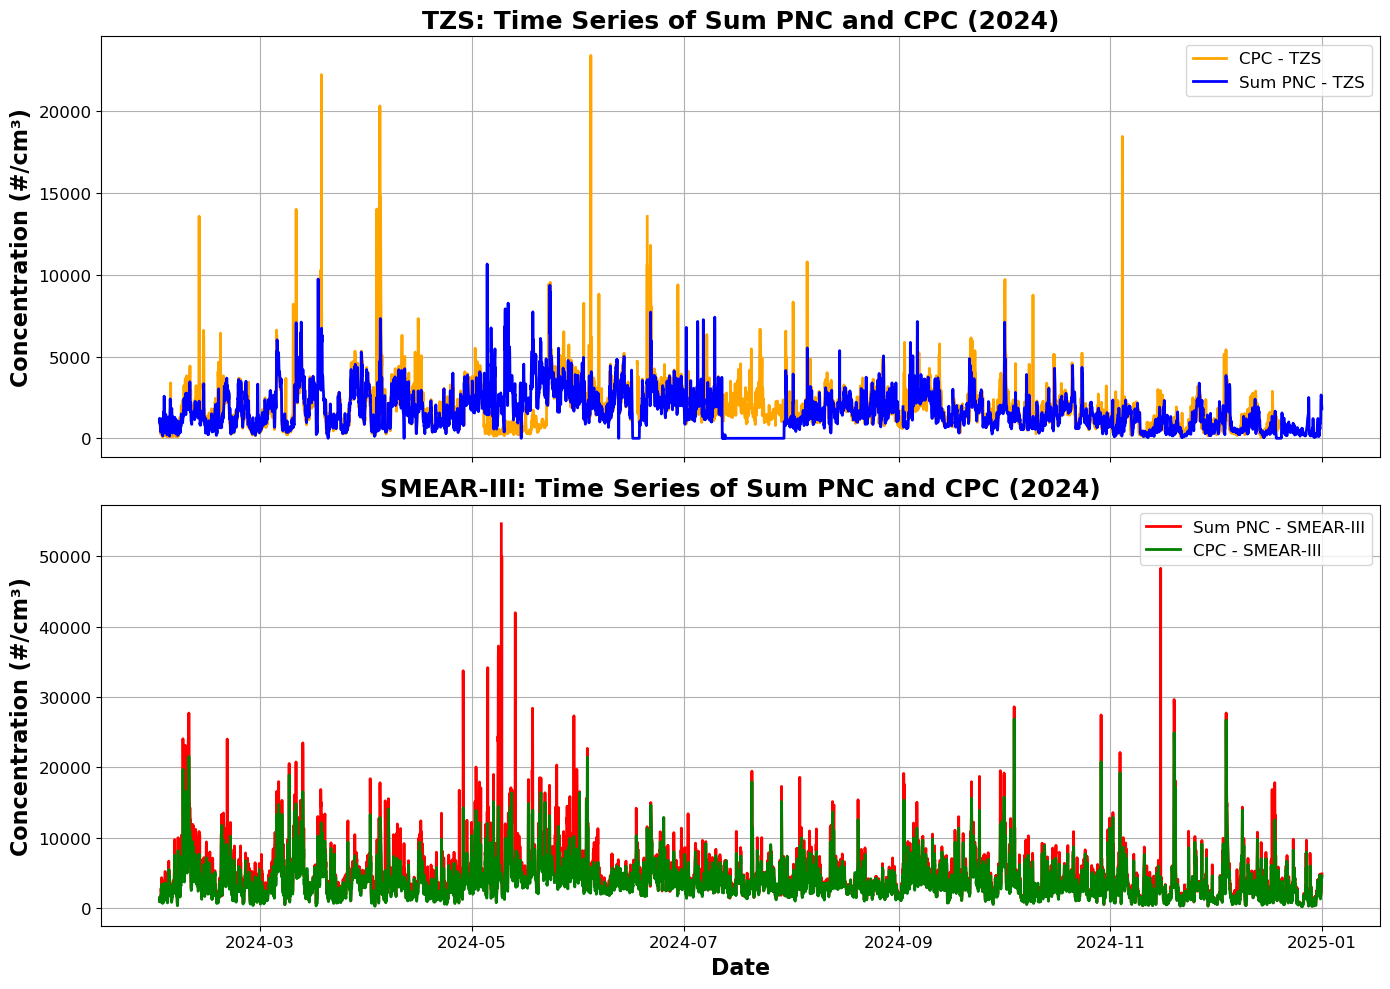

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load the data ---
file_path = '/Users/touqeergill/Desktop/TZS + SMEAR (PNC)+ CPC.xlsx'

# Read sheets
tzs_data = pd.read_excel(file_path, sheet_name='TZS')
smear_data = pd.read_excel(file_path, sheet_name='SMEAR')
tzs_cpc = pd.read_excel(file_path, sheet_name='TZS (CPC)')
smear_cpc = pd.read_excel(file_path, sheet_name='SMEAR (CPC)')

# --- Processing (use actual column names in this file) ---
tzs_data['datetime'] = pd.to_datetime(tzs_data['datetime'])
smear_data['datetime'] = pd.to_datetime(smear_data['datetime'])  # note the capital D in this sheet
tzs_cpc['datetime'] = pd.to_datetime(tzs_cpc['datetime'])
smear_cpc['datetime'] = pd.to_datetime(smear_cpc['datetime'])

# Use provided PNC columns (no bin summing needed)
tzs_data['Sum PNC'] = tzs_data['TZS (PNC)']
smear_data['Sum PNC'] = smear_data['SMART SMEAR-III (PNC)']

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- TZS Plot (CPC plotted first to stay in background) ---
ax1.plot(tzs_cpc['datetime'], tzs_cpc['TZS (CPC)'], label='CPC - TZS', color='orange', linewidth=2)
ax1.plot(tzs_data['datetime'], tzs_data['Sum PNC'], label='Sum PNC - TZS', color='blue', linewidth=2)
ax1.set_title('TZS: Time Series of Sum PNC and CPC (2024)', fontsize=18, weight='bold')
ax1.set_ylabel('Concentration (#/cm³)', fontsize=16, weight='bold')
ax1.legend(fontsize=12)
ax1.grid(True)
ax1.tick_params(axis='both', labelsize=12)

# --- SMEAR-III Plot (order unchanged) ---
ax2.plot(smear_data['datetime'], smear_data['Sum PNC'], label='Sum PNC - SMEAR-III', color='red', linewidth=2)
ax2.plot(smear_cpc['datetime'], smear_cpc['SMART SMEAR-III (CPC)'], label='CPC - SMEAR-III', color='green', linewidth=2)
ax2.set_title('SMEAR-III: Time Series of Sum PNC and CPC (2024)', fontsize=18, weight='bold')
ax2.set_xlabel('Date', fontsize=16, weight='bold')
ax2.set_ylabel('Concentration (#/cm³)', fontsize=16, weight='bold')
ax2.legend(fontsize=12)
ax2.grid(True)
ax2.tick_params(axis='both', labelsize=12)

# --- Final Layout ---
plt.tight_layout()
plt.show()

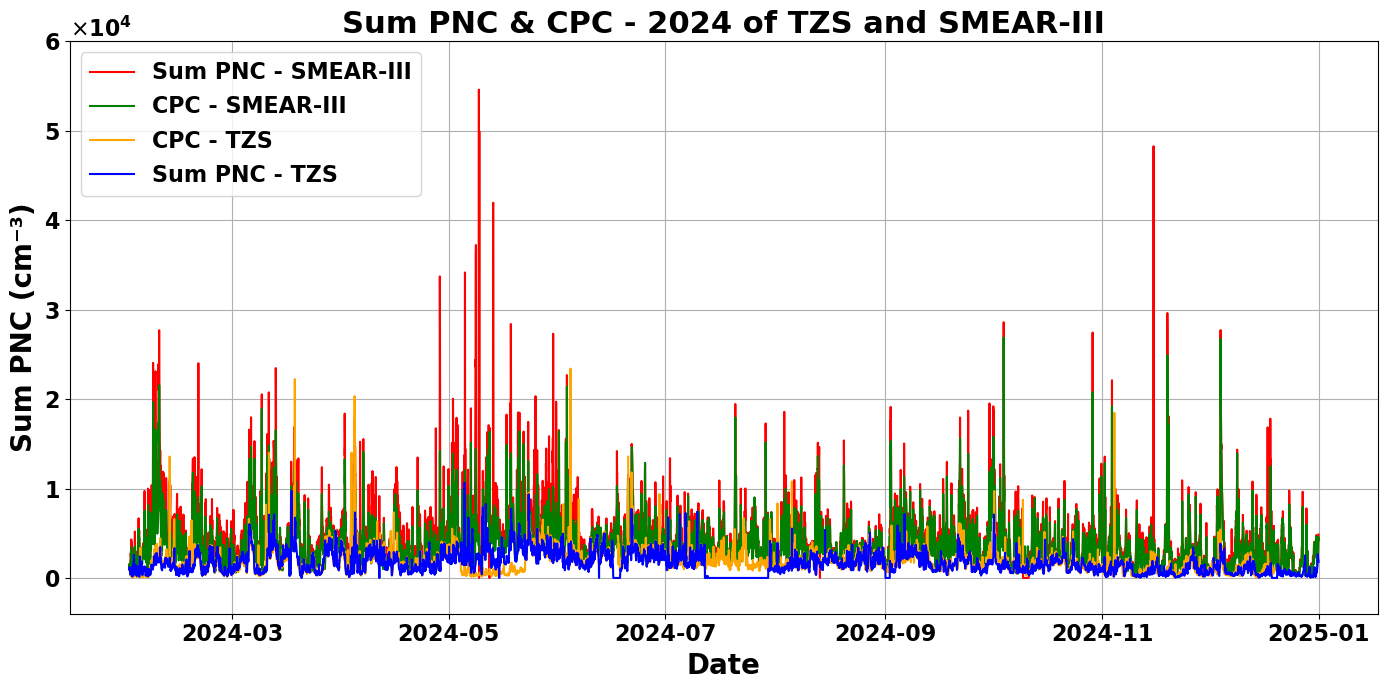

In [10]:
# this plot is made with new PNC data that was obtained from Smart smear and it gives perfect results in scattered plot



import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Load the data from the Excel file ---
file_path = '/Users/touqeergill/Desktop/TZS + SMEAR (PNC)+ CPC.xlsx'

# Read each sheet
tzs_data   = pd.read_excel(file_path, sheet_name='TZS')
smear_data = pd.read_excel(file_path, sheet_name='SMEAR')
tzs_cpc    = pd.read_excel(file_path, sheet_name='TZS (CPC)')
smear_cpc  = pd.read_excel(file_path, sheet_name='SMEAR (CPC)')

# ---------- Helpers ----------
def ensure_datetime(df):
    """Ensure a 'datetime' column exists (case-insensitive) and parse to datetime."""
    dt_col = None
    for c in df.columns:
        if str(c).strip().lower() == 'datetime':
            dt_col = c
            break
    if dt_col is None:
        raise KeyError("No 'datetime' column found (case-insensitive).")
    df['datetime'] = pd.to_datetime(df[dt_col])
    return df

def sum_pnc_bins(df):
    """
    Sum numeric PNC bin columns.
    Assumes bins are roughly in columns 2..40 (i.e., df.columns[1:40]).
    Falls back to summing all numeric columns except 'datetime' if needed.
    """
    end_idx = min(40, df.shape[1])
    candidate_cols = df.columns[1:end_idx]
    nums = df[candidate_cols].select_dtypes(include='number')
    if nums.shape[1] == 0:
        nums = df.drop(columns=['datetime'], errors='ignore').select_dtypes(include='number')
    return nums.sum(axis=1)

def find_cpc_column(df):
    """Find a numeric CPC column by name pattern (case-insensitive)."""
    candidates = [c for c in df.columns if 'cpc' in str(c).lower()]
    candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
    if candidates:
        return candidates[0]
    # Known fallbacks
    for name in ['TZS (CPC)', 'SMART SMEAR-III (CPC)', 'SMEAR-III (CPC)', 'SMEAR-III CPC', 'CPC']:
        if name in df.columns and pd.api.types.is_numeric_dtype(df[name]):
            return name
    raise KeyError("Could not find a numeric CPC column. Please check sheet headers.")
# -----------------------------

# Prepare frames
tzs_data   = ensure_datetime(tzs_data)
smear_data = ensure_datetime(smear_data)
tzs_cpc    = ensure_datetime(tzs_cpc)
smear_cpc  = ensure_datetime(smear_cpc)

# Sum PNC
tzs_data['Sum PNC']   = sum_pnc_bins(tzs_data)
smear_data['Sum PNC'] = sum_pnc_bins(smear_data)

# CPC columns
tzs_cpc_col   = find_cpc_column(tzs_cpc)
smear_cpc_col = find_cpc_column(smear_cpc)

# --- Calculate mean concentrations for plotting order ---
mean_concentrations = {
    'Sum PNC - SMEAR-III': smear_data['Sum PNC'].mean(skipna=True),
    'Sum PNC - TZS':       tzs_data['Sum PNC'].mean(skipna=True),
    'CPC - SMEAR-III':     smear_cpc[smear_cpc_col].mean(skipna=True),
    'CPC - TZS':           tzs_cpc[tzs_cpc_col].mean(skipna=True),
}

# Sort by descending mean concentration
ordered_series = sorted(mean_concentrations.items(), key=lambda x: -x[1])

# Fixed color mapping (do not change)
plot_mapping = {
    'Sum PNC - SMEAR-III': {'x': smear_data['datetime'], 'y': smear_data['Sum PNC'],            'color': 'red'},
    'Sum PNC - TZS':       {'x': tzs_data['datetime'],   'y': tzs_data['Sum PNC'],              'color': 'blue'},
    'CPC - SMEAR-III':     {'x': smear_cpc['datetime'],  'y': smear_cpc[smear_cpc_col],         'color': 'green'},
    'CPC - TZS':           {'x': tzs_cpc['datetime'],    'y': tzs_cpc[tzs_cpc_col],             'color': 'orange'},
}

# --- Plotting ---
plt.figure(figsize=(14, 7))

for label, _ in ordered_series:
    data = plot_mapping[label]
    plt.plot(data['x'], data['y'], linestyle='-', color=data['color'], label=label)

# --- Plot Formatting ---
plt.title('Sum PNC & CPC - 2024 of TZS and SMEAR-III', fontweight='bold', fontsize=22)
plt.xlabel('Date', fontweight='bold', fontsize=20)
plt.ylabel('Sum PNC (cm⁻³)', fontweight='bold', fontsize=20)

plt.grid(True)
plt.ylim(-4000, 60000)

# Scientific notation on Y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Tick and label styling
plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)
ax.yaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_fontweight('bold')

# Legend
plt.legend(prop={'size': 16, 'weight': 'bold'})

# Final layout and display
plt.tight_layout()
plt.show()

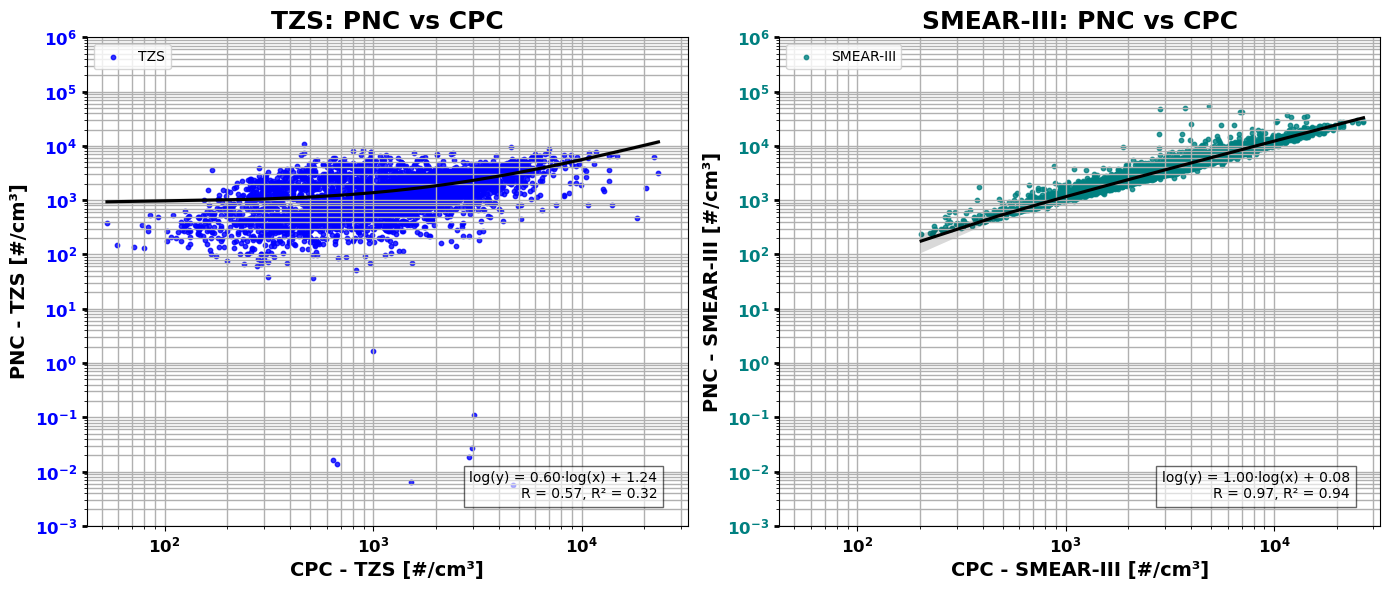

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

# =============== User settings ===============
file_path = '/Users/touqeergill/Desktop/TZS + SMEAR (PNC)+ CPC.xlsx'

# Explicit y-axis limits for log scale
Y_MIN = 1e-3   # 10^-1
Y_MAX = 1e6    # 10^8

# Optional: clamp X if you want shared bounds; set to None to auto
X_MIN = None
X_MAX = None

# Padding around data-driven min/max for axes before clamping (multipliers)
PAD_LOW = 0.8
PAD_HIGH = 1.2
# ============================================

# --- Load the data ---
tzs_pnc = pd.read_excel(file_path, sheet_name='TZS')
tzs_cpc = pd.read_excel(file_path, sheet_name='TZS (CPC)')
smear_pnc = pd.read_excel(file_path, sheet_name='SMEAR')
smear_cpc = pd.read_excel(file_path, sheet_name='SMEAR (CPC)')

# --- Convert datetime columns ---
tzs_pnc['datetime'] = pd.to_datetime(tzs_pnc['datetime'])
tzs_cpc['datetime'] = pd.to_datetime(tzs_cpc['datetime'])
smear_pnc['datetime'] = pd.to_datetime(smear_pnc['datetime'])
smear_cpc['datetime'] = pd.to_datetime(smear_cpc['datetime'])

# --- Calculate Sum PNC (DMPS total) ---
tzs_pnc['Sum PNC'] = tzs_pnc.iloc[:, 1:40].sum(axis=1)
smear_pnc['Sum PNC'] = smear_pnc.iloc[:, 1:40].sum(axis=1)

# --- Merge CPC and PNC ---
tzs_merged = pd.merge(tzs_pnc[['datetime', 'Sum PNC']], tzs_cpc, on='datetime', how='inner')
smear_merged = pd.merge(smear_pnc[['datetime', 'Sum PNC']], smear_cpc, on='datetime', how='inner')

# --- Drop missing values (use correct CPC column names) ---
tzs_cleaned = tzs_merged.dropna(subset=['Sum PNC', 'TZS (CPC)'])
smear_cleaned = smear_merged.dropna(subset=['Sum PNC', 'SMART SMEAR-III (CPC)'])

# --- Filter out non-positive values for log-log plotting ---
tzs_log = tzs_cleaned[(tzs_cleaned['Sum PNC'] > 0) & (tzs_cleaned['TZS (CPC)'] > 0)]
smear_log = smear_cleaned[(smear_cleaned['Sum PNC'] > 0) & (smear_cleaned['SMART SMEAR-III (CPC)'] > 0)]

# --- Linear regressions on log-transformed data (CPC on x, PNC on y) ---
slope_tzs_log, intercept_tzs_log, r_tzs_log, _, _ = linregress(
    np.log10(tzs_log['TZS (CPC)']), np.log10(tzs_log['Sum PNC']))
r2_tzs_log = r_tzs_log ** 2

slope_smear_log, intercept_smear_log, r_smear_log, _, _ = linregress(
    np.log10(smear_log['SMART SMEAR-III (CPC)']), np.log10(smear_log['Sum PNC']))
r2_smear_log = r_smear_log ** 2

# --- Determine shared X limits from data (Y is fixed explicitly) ---
x_min = min(tzs_log['TZS (CPC)'].min(), smear_log['SMART SMEAR-III (CPC)'].min())
x_max = max(tzs_log['TZS (CPC)'].max(), smear_log['SMART SMEAR-III (CPC)'].max())
xlo, xhi = x_min * PAD_LOW, x_max * PAD_HIGH
if X_MIN is not None: xlo = max(xlo, X_MIN)
if X_MAX is not None: xhi = min(xhi, X_MAX)
# Ensure positive/ordered for log
xlo = max(xlo, np.finfo(float).tiny)
if not (xlo < xhi):
    raise ValueError("X-axis limits collapsed after clamping; adjust X_MIN/X_MAX.")
xlim = (xlo, xhi)

# Fixed Y limits as requested
ylim = (Y_MIN, Y_MAX)

# --- Plotting in log-log scale ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Left Plot: TZS ---
sns.regplot(x='TZS (CPC)', y='Sum PNC', data=tzs_log,
            scatter=True, color='blue', line_kws={'color': 'black'},
            ax=ax1, scatter_kws={'s': 10}, label='TZS')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel("CPC - TZS [#/cm³]", fontsize=14, fontweight='bold')
ax1.set_ylabel("PNC - TZS [#/cm³]", fontsize=14, fontweight='bold')
ax1.set_title("TZS: PNC vs CPC", fontsize=18, fontweight='bold')
ax1.grid(True, which="both", linewidth=1)
ax1.tick_params(axis='y', labelcolor='blue', width=2)
ax1.legend(loc='upper left', fontsize=10, frameon=True)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontweight('bold')
eq_text_tzs = (f"log(y) = {slope_tzs_log:.2f}·log(x) + {intercept_tzs_log:.2f}\n"
               f"R = {r_tzs_log:.2f}, R² = {r2_tzs_log:.2f}")
ax1.text(0.95, 0.05, eq_text_tzs, transform=ax1.transAxes,
         fontsize=10, color="black", bbox=dict(facecolor="white", alpha=0.6),
         ha='right', va='bottom')

# --- Right Plot: SMEAR-III ---
sns.regplot(x='SMART SMEAR-III (CPC)', y='Sum PNC', data=smear_log,
            scatter=True, color='teal', line_kws={'color': 'black'},
            ax=ax2, scatter_kws={'s': 10}, label='SMEAR-III')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xlabel("CPC - SMEAR-III [#/cm³]", fontsize=14, fontweight='bold')
ax2.set_ylabel("PNC - SMEAR-III [#/cm³]", fontsize=14, fontweight='bold')
ax2.set_title("SMEAR-III: PNC vs CPC", fontsize=18, fontweight='bold')
ax2.grid(True, which="both", linewidth=1)
ax2.tick_params(axis='y', labelcolor='teal', width=2)
ax2.legend(loc='upper left', fontsize=10, frameon=True)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontweight('bold')
eq_text_smear = (f"log(y) = {slope_smear_log:.2f}·log(x) + {intercept_smear_log:.2f}\n"
                 f"R = {r_smear_log:.2f}, R² = {r2_smear_log:.2f}")
ax2.text(0.95, 0.05, eq_text_smear, transform=ax2.transAxes,
         fontsize=10, color="black", bbox=dict(facecolor="white", alpha=0.6),
         ha='right', va='bottom')

# --- Final Layout ---
plt.tight_layout()
plt.show()